In [19]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import utils
import importlib
importlib.reload(utils)
from utils import *
tfd = tfp.distributions

In [17]:
_, heldout_set = tf.keras.datasets.mnist.load_data()
labels = pd.Series(heldout_set[1])
print("Test set class count")
print(labels.value_counts())

Test set class count
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
dtype: int64


In [3]:
heldout_x = heldout_set[0]
heldout_y = heldout_set[1]

# all data
heldout_seq_all = DatasetSequence(data = (heldout_x, heldout_y))

# out of distribution
where_out = np.where(heldout_y == 3)[0].tolist()
heldout_x_out = heldout_x[where_out]
heldout_seq_out = DatasetSequence(data = (heldout_x[where_out], heldout_y[where_out]))

# in distribution
where_in = np.where(heldout_y != 3)[0].tolist()
heldout_seq_in = DatasetSequence(data = (heldout_x[where_in], heldout_y[where_in]))

### OUT OF DISTRIBUTION DATA (IMAGES OF DIGIT 3)

In [4]:
model = keras.models.load_model('mnist_bayes.tf')
num_monte_carlo = 100
probs = tf.stack([model.predict(heldout_seq_out, verbose=1)
                  for _ in range(num_monte_carlo)], axis=0)
mean_probs = tf.reduce_mean(probs, axis=0)
heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))
images = heldout_seq_out.images
labels = heldout_seq_out.labels

true_labels = list()
pred_labels = list()
plot_idxs = list()

for i in range(len(images)):
    true_label = np.argmax(labels[i])
    pred_means = np.mean(probs[:, i, :], axis=0)
    pred_label = np.argmax(pred_means)
    if pred_means[pred_label] > 0.95 and pred_label != 3:
        true_labels.append(true_label)
        pred_labels.append(pred_label)
    if pred_means[pred_label] < 0.7:
        plot_idxs.append(i)


false_confidence_pct_bayes = len(pred_labels) / len(images)
false_confidence_pct_bayes

8/8 [==============================] - 0s 42ms/step


0.23465346534653464

In [5]:
model = keras.models.load_model('mnist_nonbayes.h5')
num_monte_carlo = 100

images = heldout_seq_out.images
labels = heldout_seq_out.labels
probs = tf.stack([model(images, training=True) for _ in range(num_monte_carlo)], axis=0)
mean_probs = tf.reduce_mean(probs, axis = 0)
heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))

true_labels = list()
pred_labels = list()

for i in range(len(images)):
    true_label = np.argmax(labels[i])
    pred_means = np.mean(probs[:, i, :], axis = 0)
    pred_label = np.argmax(pred_means)
    if pred_means[pred_label] > 0.95 and pred_label != 3:
        true_labels.append(true_label)
        pred_labels.append(pred_label)

false_confidence_pct_mcd = len(pred_labels) / len(images)
false_confidence_pct_mcd

0.3584158415841584

### IN-DISTRIBUTION DATA

In [6]:
model = keras.models.load_model('mnist_bayes.tf')
num_monte_carlo = 100
probs = tf.stack([model.predict(heldout_seq_in, verbose = 1)
                  for _ in range(num_monte_carlo)], axis = 0)
mean_probs = tf.reduce_mean(probs, axis = 0)
heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))
images = heldout_seq_in.images
labels = heldout_seq_in.labels

true_labels = list()
pred_labels = list()

for i in range(len(images)):
    true_label = np.argmax(labels[i])
    pred_means = np.mean(probs[:, i, :], axis = 0)
    pred_label = np.argmax(pred_means)
    if pred_means[pred_label] > 0.95 and pred_label != 3:
        true_labels.append(true_label)
        pred_labels.append(pred_label)

accuracy_bayes = (np.array(true_labels) == np.array(pred_labels)).sum() / len(true_labels)
accuracy_bayes

71/71 [==============================] - 3s 40ms/step


0.9993887530562348

In [7]:

model = keras.models.load_model('mnist_nonbayes.h5')
num_monte_carlo = 100

images = heldout_seq_in.images
labels = heldout_seq_in.labels
probs = tf.stack([model(images, training = True) for _ in range(num_monte_carlo)], axis = 0)
mean_probs = tf.reduce_mean(probs, axis = 0)
heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))

true_labels = list()
pred_labels = list()

for i in range(len(images)):
    true_label = np.argmax(labels[i])
    pred_means = np.mean(probs[:, i, :], axis = 0)
    pred_label = np.argmax(pred_means)
    if pred_means[pred_label] > 0.95 and pred_label != 3:
        true_labels.append(true_label)
        pred_labels.append(pred_label)

accuracy_mcd = (np.array(true_labels) == np.array(pred_labels)).sum() / len(true_labels)
accuracy_mcd

0.9982991268851343

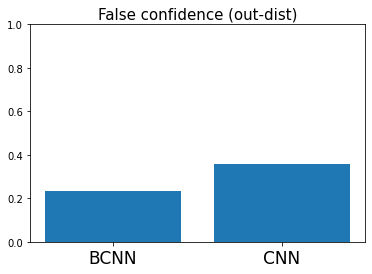

In [27]:
import matplotlib.pyplot as plt
plt.bar(['BCNN', 'CNN'], [false_confidence_pct_bayes, false_confidence_pct_mcd])
plt.ylim((0,1))
plt.title('False confidence (out-dist)', fontsize = 15)
plt.xticks(fontsize = 17)
plt.savefig('wront.pdf')

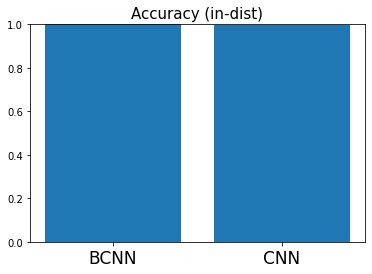

In [28]:
plt.bar(['BCNN', 'CNN'], [accuracy_bayes, accuracy_mcd])
plt.ylim((0,1))
plt.title('Accuracy (in-dist)', fontsize = 15)
plt.xticks(fontsize = 17)
plt.savefig('acc.pdf')


### SAMPLE PLOTS

In [21]:
model = keras.models.load_model('models/mnist_bayes.tf')
num_monte_carlo = 5
images = heldout_seq_out.images[plot_idxs]
labels = heldout_seq_out.labels
probs = tf.stack([model.predict(images, verbose=1)
                  for _ in range(num_monte_carlo)], axis=0)
mean_probs = tf.reduce_mean(probs, axis=0)
heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))
#
for i in range(0,len(images)//10):
    plot_heldout_prediction(heldout_seq_out.images[10*i:10*i+10],
                            probs.numpy()[:,10*i:10*i+10,:],
                            fname = f'plots/bayes_{i}.png', n = 1)

13/13 [==============================] - 0s 19ms/step


C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

In [22]:
for i in range(0,len(images)//10):
    plot_heldout_prediction(heldout_seq_out.images[10*i:10*i+10],
                            probs.numpy()[:,10*i:10*i+10,:],
                            fname = f'plots/bayes_1_{i}.png', n = 1)

C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

In [23]:
model = keras.models.load_model('models/mnist_nonbayes.h5')
num_monte_carlo = 100

images = heldout_seq_out.images[plot_idxs]
labels = heldout_seq_out.labels
probs = tf.stack([model(images, training=True) for _ in range(num_monte_carlo)], axis=0)
mean_probs = tf.reduce_mean(probs, axis = 0)
heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))

for i in range(0,len(heldout_seq_out.images)//10):
    plot_heldout_prediction(heldout_seq_out.images[10*i:10*i+10],
                            probs.numpy()[:,10*i:10*i+10,:],
                            fname = f'plots/mcd_1_{i}.png', n = 1)

C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

IndexError: index 0 is out of bounds for axis 0 with size 0